# Skip Connections and ResNets in Keras


This notebook shows how to construct skip connections in Keras. This requires a slightly different workflow since we cannot rely on the Sequential API to construct the shortcut paths in the network graph. We instead need to use the functional API of Keras.

The notebook shows how to build a small ResNet-like model and train it from scratch on the cat-dog dataset. Apart from the functional API, you will also learn that there are very subtle but sometimes important details we have to keep in mind when building and training ResNets.

Main sources:

 * He et al. 2015: [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
 * He et al. 2016: [Identity Mappings in Deep Residual Networks](https://arxiv.org/abs/1603.05027)

### Preparation

Lets load the cats-dogs dataset from day1.

In [1]:
import os

base_dir = os.path.join('..', '..', 'data','cats-dogs')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras import optimizers, callbacks
from keras.regularizers import l2
from keras.layers import Dropout, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Input, GlobalAveragePooling2D, Dense, add

Using TensorFlow backend.


An important parameter for models using the BatchNormalization layer is the batch size. Since BatchNormalization computes statistics like mean and variance across the batch dimension, the batch size should not be too small. Otherwise, we might get very bad estimates of these means and variances and thus trianing might stall. Batch sizes below 8 are definitely too low.

Also see:
 * [Batch Renormalization: Towards Reducing Minibatch Dependence in Batch-Normalized Models](https://arxiv.org/pdf/1702.03275.pdf)
 
Lets go for batch size 64, but you can decrease this to 32 if your GPU does not have enough RAM.

In [3]:
batch_size = 64

We'll train on the typical ImageNet size of 224x224 pixels. 

In [4]:
image_size = (224, 224)

Next, we setup an image data generator for data augmentation. 

In [5]:
# use data augmentation in train set
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# only rescale pixels in test/validation set
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## Model Construction

We now want to construct residual blocks as shown in the image below, in Keras. Given an input tensor x_l we pass this tensor through a conv block (right side), then add the resulting residual to x_l to obtain the input to the next layer.

![](../../images/resnet-proposed.png)

Let us first start by defining a helper function that constructs a Conv2D layer. This is simply to reduce code duplication. We set the initializer and regularizer according to the ResNet paper.

In [6]:
def conv(num_filters, kernel_size=3, **kw):
    # helper function to construct a conv layer
    return Conv2D(num_filters, kernel_size, padding='same', 
                  kernel_initializer='he_normal', kernel_regularizer=l2(1.e-4), 
                  **kw)

### Identity Blocks

Next, we build function that implements the residual block shown above. Lets call this identity block since it passes the in_tensor directly through the add.

In [7]:
def identity_block(in_tensor):
    num_filters = int(in_tensor.get_shape()[3])
    
    x = BatchNormalization()(in_tensor) # BN
    x = Activation('relu')(x)           # ReLU
    x = conv(num_filters, 3)(x)         # weight
    x = BatchNormalization()(x)         # BN
    x = Activation('relu')(x)           # ReLU
    x = conv(num_filters, 3)(x)         # weight
    
    return add([x, in_tensor])          # addition

Here, we used the functional API from Keras. Lets show an example how to instantiate such an identity block in a model:

In [8]:
input_tensor = Input(shape=(32, 32, 3))
output = identity_block(input_tensor)
model = Model(inputs=input_tensor, outputs=output)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 32, 32, 3)     12          input_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 32, 3)     0           batch_normalization_1[0][0]      
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 32, 32, 3)     84          activation_1[0][0]               
___________________________________________________________________________________________

### Projection Blocks

Normally in a CNN, we *decrease* image size and *increase* the number of filters (using pooling) after a certain network depth. But we cannot do such a thing inside the identity block on the residual path: we cannot *add both paths together anymore if we do a downsampling on one of the paths*. ResNets solve this using 1x1 convolutions in the identity path. For example, if our current feature maps are WxHx32 and now we want to have WxHx64, we add a 1x1 conv filter with 64 filters. But how do we perform the pooling then?

ResNets *do not perform any pooling*. Instead, they just use strided convolutions.

Notice that in the projection block, we also have to be careful where to apply the BN and ReLU layers. Remember that the residual path in any identity block ends with a conv (in pre-activation ResNets)! We always want to do BN and ReLU before going into the next conv. With this in mind, we can now code this projection block:

In [9]:
def projection_block(in_tensor, num_filters, stride=2):    
    preactivated = BatchNormalization()(in_tensor)
    preactivated = Activation('relu')(preactivated)
    
    # weight path computes the residual x
    x = conv(num_filters, 3, strides=stride)(preactivated)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = conv(num_filters, 3)(x)
    
    # residual path: 1x1 projection with subsampling
    shortcut = conv(num_filters, 1, strides=stride)(preactivated)
    
    # x and shortcut are now the same format, can add them
    return add([x, shortcut])

### Building the full ResNet

Lets build a ResNet!

ResNets typically add an initial conv layer that brings down the image size of 224x224 down to 56x56. This first layer is supposed to capture the high-detail image information. After that, only 3x3 convs are used. So, the bottom of our network shall look like this:

In [10]:
image_input = Input(shape=(image_size[0], image_size[1], 3))
x = conv(16, 7, strides=2)(image_input) # 7x7 conv, stride 2, 16 filters
x = MaxPooling2D(3, strides=2, padding='same')(x) # 3x3 pool, stride 2

Next, we want to add a projection block without downsampling. This will also ensure that the identity path gets a BN and a ReLU.

In [11]:
x = projection_block(x, 16, stride=1) # no subsampling in first block
print("output after first projection block: ", x.get_shape())

output after first projection block:  (?, 56, 56, 16)


After this we can just add identity blocks, followed by projection blocks that also do subsampling:

In [12]:
x = identity_block(x)
x = identity_block(x)
x = projection_block(x, 32)
print("output after 1st stage: ", x.get_shape())

x = identity_block(x)
x = identity_block(x)
x = projection_block(x, 64)
print("output after 2nd stage: ", x.get_shape())

x = identity_block(x)
x = identity_block(x)
x = projection_block(x, 128)
print("output after 3rd stage: ", x.get_shape())

x = identity_block(x)
x = identity_block(x)
print("output after 4th stage: ", x.get_shape())

output after 1st stage:  (?, 28, 28, 32)
output after 2nd stage:  (?, 14, 14, 64)
output after 3rd stage:  (?, 7, 7, 128)
output after 4th stage:  (?, 7, 7, 128)


You now expect that we flatten this last 7x7x64 tensor to pass it to some fully connected network part, right? Wrong. ResNets just average-pool over the whole feature map. The idea behind this is that after all those identity blocks, the receptive field should cover the whole image anyway (especially for a deep ResNet), so we can just throw away any remaining spatial information. You may not want to do this if you want to use a ResNet as a basis for a segmentation net. But here, we're doing classification, so that is ok. 

Also, we have to be careful again with the preactivation thing. After the last identity block, we are missing a BN-ReLU layer, so lets not forget that one.

In [13]:
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = GlobalAveragePooling2D()(x)
print("output after global avg pool: ", x.get_shape())
output = Dense(1, kernel_initializer='he_normal', activation='sigmoid')(x)

output after global avg pool:  (?, 128)


Next, construct the model and compile:

In [14]:
model = Model(inputs=image_input, outputs=output)
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(momentum=0.9),
              metrics=['accuracy'])

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 112, 112, 16)  2368        input_2[0][0]                    
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 56, 56, 16)    0           conv2d_3[0][0]                   
____________________________________________________________________________________________________
batch_normalization_3 (BatchNorm (None, 56, 56, 16)    64          max_pooling2d_1[0][0]            
___________________________________________________________________________________________

Total params: 1,099,281
Trainable params: 1,096,369
Non-trainable params: 2,912
____________________________________________________________________________________________________


## Training

Training ResNets comes with its own best practices. You also saw that we used a different initialization ('he_normal') and a small weight decay (l2 regularization with 0.0001) in the conv filters. This is a subtle detail and people found that such settings produce slightly better networks. 

The good news is that, thanks to BatchNormalization, we can use a huge learning rates. We're also not going to use any special optimizers such as Adam, since they (sometimes) do not play very well with BatchNorm. Instead, people usually use a learning rate schedule where they start with a high learning rate, then drop the learning rate after some epochs. 

There are now even smarter methods of learning rate scheduling, but here I wanted to stay close to the ResNet paper. But here are some links:

 * [https://keras.io/callbacks/#reducelronplateau](ReduceLROnPlateau callback in Keras)
 * [https://arxiv.org/abs/1506.01186](Cyclical Learning Rates for Training Neural Networks)


In [15]:
def lr_schedule(epoch):
    if epoch < 30:
        return 0.1
    elif epoch < 60:
        return 0.01
    else:
        return 0.001
    

history = model.fit_generator(
    train_generator,
    steps_per_epoch=2000 // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=800 // batch_size,
    callbacks=[callbacks.LearningRateScheduler(lr_schedule)],
)

Epoch 1/100
31/31 [==============================] - 14s - loss: 0.9619 - acc: 0.5439 - val_loss: 1.9647 - val_acc: 0.4753
Epoch 2/100
31/31 [==============================] - 14s - loss: 0.9408 - acc: 0.5962 - val_loss: 8.3910 - val_acc: 0.4948
Epoch 3/100
31/31 [==============================] - 14s - loss: 0.9190 - acc: 0.6205 - val_loss: 3.4659 - val_acc: 0.4961
Epoch 4/100
31/31 [==============================] - 14s - loss: 0.8905 - acc: 0.6477 - val_loss: 1.3286 - val_acc: 0.5169
Epoch 5/100
31/31 [==============================] - 14s - loss: 0.8763 - acc: 0.6573 - val_loss: 5.2966 - val_acc: 0.5156
Epoch 6/100
31/31 [==============================] - 14s - loss: 0.8652 - acc: 0.6819 - val_loss: 0.9121 - val_acc: 0.6146
Epoch 7/100
31/31 [==============================] - 14s - loss: 0.8435 - acc: 0.6881 - val_loss: 0.9582 - val_acc: 0.6107
Epoch 8/100
31/31 [==============================] - 14s - loss: 0.8398 - acc: 0.6906 - val_loss: 0.8704 - val_acc: 0.6536
Epoch 9/100
31/3

31/31 [==============================] - 14s - loss: 0.3148 - acc: 0.9593 - val_loss: 0.6169 - val_acc: 0.8646
Epoch 68/100
31/31 [==============================] - 14s - loss: 0.2907 - acc: 0.9707 - val_loss: 0.6314 - val_acc: 0.8646
Epoch 69/100
31/31 [==============================] - 14s - loss: 0.2832 - acc: 0.9702 - val_loss: 0.6430 - val_acc: 0.8568
Epoch 70/100
31/31 [==============================] - 14s - loss: 0.2810 - acc: 0.9744 - val_loss: 0.6626 - val_acc: 0.8516
Epoch 71/100
31/31 [==============================] - 14s - loss: 0.2759 - acc: 0.9789 - val_loss: 0.6520 - val_acc: 0.8542
Epoch 72/100
31/31 [==============================] - 14s - loss: 0.2834 - acc: 0.9734 - val_loss: 0.6373 - val_acc: 0.8568
Epoch 73/100
31/31 [==============================] - 14s - loss: 0.2771 - acc: 0.9768 - val_loss: 0.6280 - val_acc: 0.8620
Epoch 74/100
31/31 [==============================] - 14s - loss: 0.2655 - acc: 0.9823 - val_loss: 0.6417 - val_acc: 0.8516
Epoch 75/100
31/31 [=

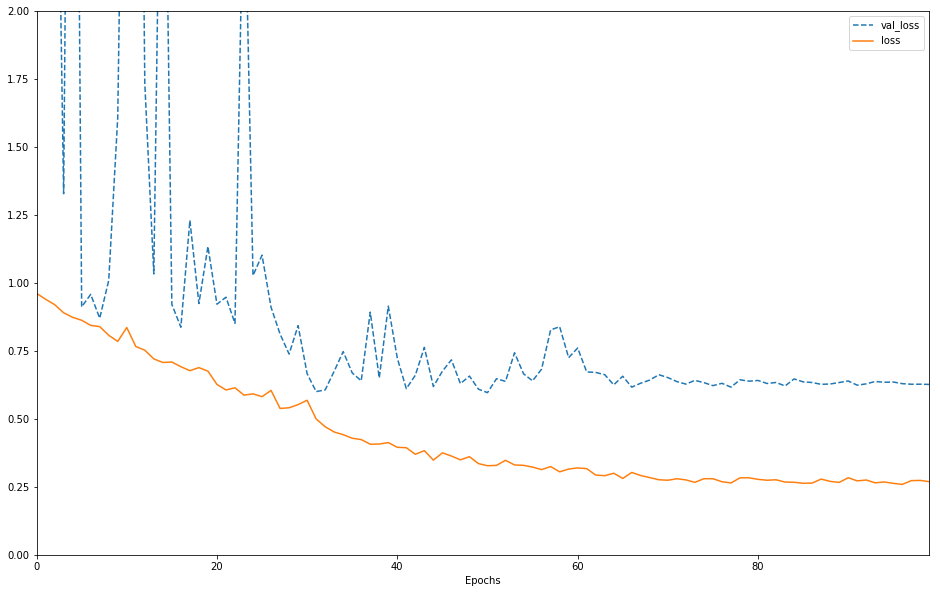

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.figure(figsize=(16,10))
plt.plot(history.epoch, history.history['val_loss'], '--', label='val_loss')
plt.plot(history.epoch, history.history['loss'], label='loss')

plt.xlabel('Epochs')
plt.legend()

plt.xlim([0, max(history.epoch)])
plt.ylim([0, 2])
plt.show()

## Further Reading
 
Why do ResNets work so well? The original paper states that the identity connections attack the vanishing/exploding gradient problem. But since batchnorm should take care of this already, this cannot be the full story. There are now a couple of theories on this. Here are two I like best:

 * Balduzzi et al.: [The Shattered Gradients Problem: If resnets are the answer, then what is the question?](https://arxiv.org/abs/1702.08591)
 * Orhan & Pitkow: [Skip Connections Eliminate Singularities](https://arxiv.org/abs/1701.09175)